# Introduction

The main purpose of this product is for the HR department to gain an overview of the company.

This has been accomplished through the use of important KPI's which are supplemented with useful graphs and information required to gain a proper insight into the state of the company.

We have also used supervised machine learning to predict probability of attrition while showing specific indicators and unsupervised learning to help us understand clusters which might be formed within the company, as these clusters could signal action is required.



#Installing Packages & Importing Data

In [1]:
!pip install xgboost -U -q 
!pip install sklearn -U -q
!pip install shap -U -q
!pip install umap-learn -q

In [2]:
import pandas as pd
import numpy as np
import altair as alt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import shap
import pickle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt


We import our three datasets


In [3]:
data1 = pd.read_csv('/content/employee_survey_data.csv')

In [4]:
data2 = pd.read_csv('/content/general_data.csv')

In [5]:
data3 = pd.read_csv('/content/manager_survey_data.csv')

Let's have an overview about every single dataset

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB


In [7]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [8]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB


Merging the Data

In [9]:
data = data3.merge(data2, on="EmployeeID", how="right").merge(data1, on="EmployeeID", how="right")

In [10]:
# let's have a look on the new dataset
data.head()

EmployeeID  JobInvolvement  PerformanceRating  Age Attrition  \
0           1               3                  3   51        No   
1           2               2                  4   31       Yes   
2           3               3                  3   32        No   
3           4               2                  3   38        No   
4           5               3                  3   32        No   

      BusinessTravel              Department  DistanceFromHome  Education  \
0      Travel_Rarely                   Sales                 6          2   
1  Travel_Frequently  Research & Development                10          1   
2  Travel_Frequently  Research & Development                17          4   
3         Non-Travel  Research & Development                 2          5   
4      Travel_Rarely  Research & Development                10          1   

  EducationField  ...  StandardHours StockOptionLevel  TotalWorkingYears  \
0  Life Sciences  ...              8                0                1.0   
1  Life Sciences  ...              8                1                6.0   
2          Other  ...              8                3                5.0   
3  Life Sciences  ...              8                3               13.0   
4        Medical  ...              8                2                9.0   

  TrainingTimesLastYear YearsAtCompany  YearsSinceLastPromotion  \
0                     6              1                        0   
1                     3              5                        1   
2                     2              5                        0   
3                     5              8                        7   
4                     2              6                        0   

   YearsWithCurrManager EnvironmentSatisfaction  JobSatisfaction  \
0                     0                     3.0              4.0   
1                     4                     3.0              2.0   
2                     3                     2.0              2.0   
3                     5                     4.0              4.0   
4                     4                     4.0              1.0   

   WorkLifeBalance  
0              2.0  
1              4.0  
2              1.0  
3              3.0  
4              3.0  

[5 rows x 29 columns]

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   JobInvolvement           4410 non-null   int64  
 2   PerformanceRating        4410 non-null   int64  
 3   Age                      4410 non-null   int64  
 4   Attrition                4410 non-null   object 
 5   BusinessTravel           4410 non-null   object 
 6   Department               4410 non-null   object 
 7   DistanceFromHome         4410 non-null   int64  
 8   Education                4410 non-null   int64  
 9   EducationField           4410 non-null   object 
 10  EmployeeCount            4410 non-null   int64  
 11  Gender                   4410 non-null   object 
 12  JobLevel                 4410 non-null   int64  
 13  JobRole                  4410 non-null   object 
 14  MaritalStatus           

In [12]:
data.shape

(4410, 29)

In [13]:
# let's see if there are duplicated columns
data.duplicated().sum()

0

In [14]:
#Print all of the data unique values and value count
for column in data.columns: 
  if data[column].dtype == object:
    print(str(column)+ ':' + str(data[column].unique()))
    print(data[column].value_counts())
    print('                                            ')

Attrition:['No' 'Yes']
No     3699
Yes     711
Name: Attrition, dtype: int64
                                            
BusinessTravel:['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Travel_Rarely        3129
Travel_Frequently     831
Non-Travel            450
Name: BusinessTravel, dtype: int64
                                            
Department:['Sales' 'Research & Development' 'Human Resources']
Research & Development    2883
Sales                     1338
Human Resources            189
Name: Department, dtype: int64
                                            
EducationField:['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Life Sciences       1818
Medical             1392
Marketing            477
Technical Degree     396
Other                246
Human Resources       81
Name: EducationField, dtype: int64
                                            
Gender:['Female' 'Male']
Male      2646
Female    1764
Name: Gender, dtype: int64
        

In [15]:
#Print all of the data unique values and value count
for column in data.columns: 
  if data[column].dtype == float:
    print(str(column)+ ':' + str(data[column].unique()))
    print(data[column].value_counts())
    print('                                            ')

NumCompaniesWorked:[ 1.  0.  3.  4.  2.  7.  9.  5.  6.  8. nan]
1.0    1558
0.0     586
3.0     474
2.0     438
4.0     415
7.0     222
6.0     208
5.0     187
9.0     156
8.0     147
Name: NumCompaniesWorked, dtype: int64
                                            
TotalWorkingYears:[ 1.  6.  5. 13.  9. 28. 10. 21. 16. 37.  7.  3. 15.  8. nan 12. 17. 19.
 22.  2.  4. 23.  0. 11. 24. 25. 20. 14. 26. 18. 30. 36. 31. 33. 32. 34.
 40. 29. 35. 27. 38.]
10.0    605
6.0     375
8.0     307
9.0     287
5.0     264
7.0     243
1.0     242
4.0     189
12.0    144
3.0     126
15.0    120
16.0    111
13.0    108
11.0    106
21.0    102
17.0     99
14.0     93
2.0      93
20.0     89
18.0     81
23.0     66
19.0     66
22.0     62
24.0     54
25.0     42
26.0     42
28.0     42
0.0      33
29.0     30
31.0     27
32.0     27
27.0     21
30.0     21
33.0     21
36.0     18
34.0     15
37.0     12
35.0      9
40.0      6
38.0      3
Name: TotalWorkingYears, dtype: int64
                           

In [16]:
#Print all of the data unique values and value count
for column in data.columns: 
  if data[column].dtype == int:
    print(str(column)+ ':' + str(data[column].unique()))
    print(data[column].value_counts())
    print('                                            ')

EmployeeID:[   1    2    3 ... 4408 4409 4410]
1       1
2938    1
2944    1
2943    1
2942    1
       ..
1477    1
1478    1
1479    1
1480    1
4410    1
Name: EmployeeID, Length: 4410, dtype: int64
                                            
JobInvolvement:[3 2 1 4]
3    2604
2    1125
4     432
1     249
Name: JobInvolvement, dtype: int64
                                            
PerformanceRating:[3 4]
3    3732
4     678
Name: PerformanceRating, dtype: int64
                                            
Age:[51 31 32 38 46 28 29 25 45 36 55 47 37 21 35 26 50 53 42 44 49 18 41 39
 58 33 43 52 27 30 54 40 23 48 57 34 24 22 56 60 19 20 59]
35    234
34    231
31    207
36    207
29    204
32    183
30    180
38    174
33    174
40    171
37    150
28    144
27    144
42    138
39    126
45    123
41    120
26    117
46     99
44     99
43     96
50     90
24     78
25     78
49     72
47     72
55     66
48     57
51     57
53     57
52     54
54     54
22     48
58     42
23   

Because we gained insides about the unique values and the value count, we can now determine which variables we can drop and transfer the variables with the type "float" to integers.

In [17]:
data=data.drop(['MaritalStatus','StandardHours', 'EmployeeCount', 'Over18'], axis=1)

We dropped "Standard Hours", "Employee Count" and "Over 18" because these variables do not add information. We also dropped "Martial Status" because this could lead to discrimination in the prediction. 

Now we have to clean the data. We are searching for the NaNs and deleting them.

In [18]:
#overview if there are 0/ Nans
data.isna().sum()

EmployeeID                  0
JobInvolvement              0
PerformanceRating           0
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
Gender                      0
JobLevel                    0
JobRole                     0
MonthlyIncome               0
NumCompaniesWorked         19
PercentSalaryHike           0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

In [19]:
# deleting the Nans
data = data.dropna()

In [20]:
# let's check if there are some left
data.isna().sum()

EmployeeID                 0
JobInvolvement             0
PerformanceRating          0
Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
Gender                     0
JobLevel                   0
JobRole                    0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
dtype: int64

Organizing the data by type helps to use indexing 

In [21]:
# Organizing the data by type
data=data[['Attrition', 'BusinessTravel', 'Department','EducationField', 'Gender','JobRole', 'DistanceFromHome',
       'Education', 'EmployeeID', 'JobLevel',
        'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating','Age']]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 4408
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Attrition                4300 non-null   object 
 1   BusinessTravel           4300 non-null   object 
 2   Department               4300 non-null   object 
 3   EducationField           4300 non-null   object 
 4   Gender                   4300 non-null   object 
 5   JobRole                  4300 non-null   object 
 6   DistanceFromHome         4300 non-null   int64  
 7   Education                4300 non-null   int64  
 8   EmployeeID               4300 non-null   int64  
 9   JobLevel                 4300 non-null   int64  
 10  MonthlyIncome            4300 non-null   int64  
 11  NumCompaniesWorked       4300 non-null   float64
 12  PercentSalaryHike        4300 non-null   int64  
 13  StockOptionLevel         4300 non-null   int64  
 14  TotalWorkingYears       

To get a feeling about the relationships between the variables, we have a look at the correlation matrix.
The strongest correlation is between "Years at Company" and "Years with Current Manager".

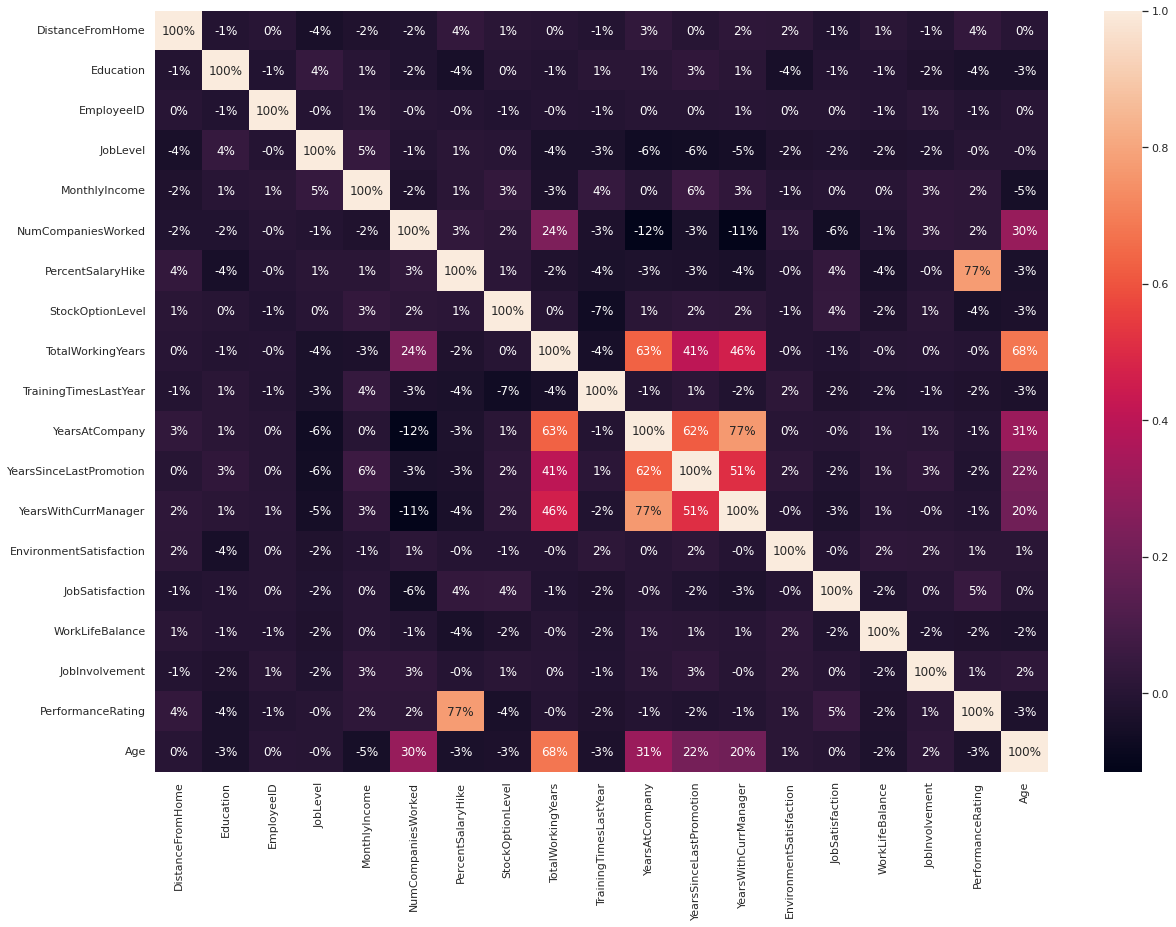

In [23]:
plt.figure(figsize=(20,14))
sns.heatmap(data.corr(), annot=True, fmt= '.0%')

#State of the Art HR - EDA

We want to gain more insides about "Attrition".

In [24]:
#Count people who left and stayed at the company
print(len(data[data['Attrition']=='Yes']))
print(len(data[data['Attrition']=='No']))
print("percentage of people that left  the company is:",(len(data[data['Attrition']=='Yes'])/len(data))*100,"%")
print("percentage of people staying in the company is:",(len(data[data['Attrition']=='No'])/len(data))*100,"%")

695
3605
percentage of people that left  the company is: 16.162790697674417 %
percentage of people staying in the company is: 83.83720930232558 %


In [25]:
alt.Chart(data).mark_bar().encode(x='Age',y='sum(Age)',color='Attrition').properties(width=700).interactive()

alt.Chart(...)

It shows, that the age group between 28 and 31 was the biggest group leaving the company.

In [26]:
alt.Chart(data).mark_rect().encode( 
    x='JobLevel',
    y='JobRole',
    color='JobSatisfaction'
).properties(width=200)

alt.Chart(...)

Here we can see, that the Job Satisfaction is mostly low in the first years. There is a strong contrast between the Job Roles of "Laboratory Technican" and "Manager" (very low) and Human Resources and "Sales Representative" (very high). 


#Unsupervised Machine Learning (UML)

In this step, we apply Unsupervised Machine Learning (UML). For a human resource team, the insights from the analysis could be helpful in identifying new associations about their employees that they were not aware of before. For example, clustering algorithms can help to show if there are any group formations within the employees and then identify specific "types" of employees based on this. After conducting the analysis, these groupings can be named and then visualised.

##Feature Engineering & Preprocessing UML

In [27]:
#let's have an overview about the data again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 4408
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Attrition                4300 non-null   object 
 1   BusinessTravel           4300 non-null   object 
 2   Department               4300 non-null   object 
 3   EducationField           4300 non-null   object 
 4   Gender                   4300 non-null   object 
 5   JobRole                  4300 non-null   object 
 6   DistanceFromHome         4300 non-null   int64  
 7   Education                4300 non-null   int64  
 8   EmployeeID               4300 non-null   int64  
 9   JobLevel                 4300 non-null   int64  
 10  MonthlyIncome            4300 non-null   int64  
 11  NumCompaniesWorked       4300 non-null   float64
 12  PercentSalaryHike        4300 non-null   int64  
 13  StockOptionLevel         4300 non-null   int64  
 14  TotalWorkingYears       

In [28]:
# We select only numerical features from our data. So our selection includes all rows and starts at the 6th column.  
data_to_cluster = data.iloc[:, 6:]

In [29]:
#let's see, if we have included the variables that we want to use
data_to_cluster 

DistanceFromHome  Education  EmployeeID  JobLevel  MonthlyIncome  \
0                    6          2           1         1         131160   
1                   10          1           2         1          41890   
2                   17          4           3         4         193280   
3                    2          5           4         3          83210   
4                   10          1           5         1          23420   
...                ...        ...         ...       ...            ...   
4404                 4          3        4405         2          35390   
4405                 5          4        4406         1          60290   
4406                 2          4        4407         1          26790   
4407                25          2        4408         2          37020   
4408                18          2        4409         1          23980   

      NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  \
0                    1.0                 11                 0   
1                    0.0                 23                 1   
2                    1.0                 15                 3   
3                    3.0                 11                 3   
4                    4.0                 12                 2   
...                  ...                ...               ...   
4404                 1.0                 18                 0   
4405                 3.0                 17                 1   
4406                 2.0                 15                 0   
4407                 0.0                 20                 0   
4408                 0.0                 14                 1   

      TotalWorkingYears  TrainingTimesLastYear  YearsAtCompany  \
0                   1.0                      6               1   
1                   6.0                      3               5   
2                   5.0                      2               5   
3                  13.0                      5               8   
4                   9.0                      2               6   
...                 ...                    ...             ...   
4404                6.0                      2               6   
4405               10.0                      5               3   
4406               10.0                      2               3   
4407                5.0                      4               4   
4408               10.0                      2               9   

      YearsSinceLastPromotion  YearsWithCurrManager  EnvironmentSatisfaction  \
0                           0                     0                      3.0   
1                           1                     4                      3.0   
2                           0                     3                      2.0   
3                           7                     5                      4.0   
4                           0                     4                      4.0   
...                       ...                   ...                      ...   
4404                        1                     5                      3.0   
4405                        0                     2                      4.0   
4406                        0                     2                      4.0   
4407                        1                     2                      1.0   
4408                        7                     8                      4.0   

      JobSatisfaction  WorkLifeBalance  JobInvolvement  PerformanceRating  Age  
0                 4.0              2.0               3                  3   51  
1                 2.0              4.0               2                  4   31  
2                 2.0              1.0               3                  3   32  
3                 4.0              3.0               2                  3   38  
4                 1.0              3.0               3                  3   32  
...               ...              ...             ...                ...  ...  
4404           

Now we have to scale our data. First, we are using a standard scaling algorithm (StandardScaler). It allows us to compare the scores with different metrics directly and make a statement about them.

In [30]:
# import and instantiate scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [31]:
data_to_cluster_scaled = scaler.fit_transform(data_to_cluster)

The second scaling method we are using is the MinMaxScaling. In this approach the data is scaled to a fixed range.

In [32]:
# import MinMaxScaler from Sklearn
from sklearn.preprocessing import MinMaxScaler
scaler_min_max = MinMaxScaler()

In [33]:
# fitting the data 
data_to_cluster_minmax = scaler_min_max.fit_transform(data_to_cluster)

We can compare our data before and after scaling by visualising the changes. This gives us a better overview of what exactly happened during scaling.

In [34]:
 data_to_cluster_minmax

array([[1.78571429e-01, 2.50000000e-01, 0.00000000e+00, ...,
        6.66666667e-01, 0.00000000e+00, 7.85714286e-01],
       [3.21428571e-01, 0.00000000e+00, 2.26860254e-04, ...,
        3.33333333e-01, 1.00000000e+00, 3.09523810e-01],
       [5.71428571e-01, 7.50000000e-01, 4.53720508e-04, ...,
        6.66666667e-01, 0.00000000e+00, 3.33333333e-01],
       ...,
       [3.57142857e-02, 7.50000000e-01, 9.99546279e-01, ...,
        3.33333333e-01, 0.00000000e+00, 2.61904762e-01],
       [8.57142857e-01, 2.50000000e-01, 9.99773140e-01, ...,
        6.66666667e-01, 1.00000000e+00, 1.66666667e-01],
       [6.07142857e-01, 2.50000000e-01, 1.00000000e+00, ...,
        3.33333333e-01, 0.00000000e+00, 5.71428571e-01]])

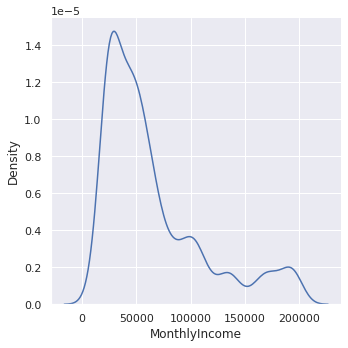

In [35]:
# monthlyIncome (pre-scaling)
sns.displot(data=data_to_cluster, 
            x="MonthlyIncome",
            kind="kde")

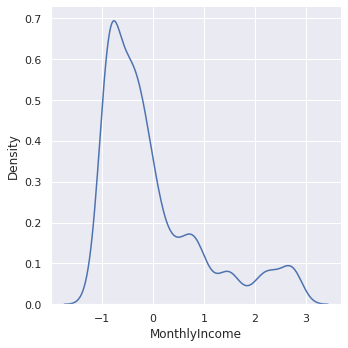

In [36]:
# MonthlyIncome(post-scaling)
sns.displot(data=pd.DataFrame(data_to_cluster_scaled, columns=data_to_cluster.columns), 
            x="MonthlyIncome",
            kind="kde")

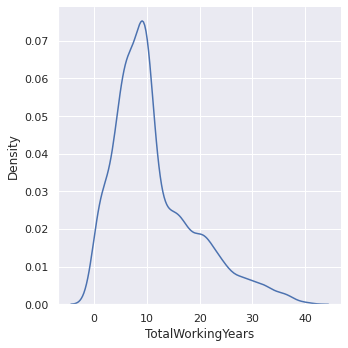

In [37]:
# Total Working Years (pre-scaling)
sns.displot(data=data_to_cluster, 
            x="TotalWorkingYears",
            kind="kde")

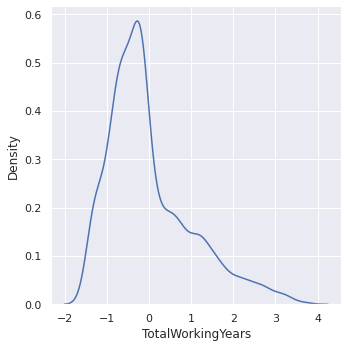

In [38]:
# Total Working Years (post-scaling)
sns.displot(data=pd.DataFrame(data_to_cluster_scaled, columns=data_to_cluster.columns), 
            x="TotalWorkingYears",
            kind="kde")

##PCA

We are now done preparing the data and can apply our first grouping algorithm.

The dimensionality reduction technique known as principal component analysis (PCA) works by finding correlations and patterns in a dataset such that it can be turned into a dataset with a much lower dimension without losing any relevant information.


In [39]:
# First step: Import PCA from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [ ]:
# Fit the model with X and apply the dimensionality reduction on X.
data_reduced_pca = pca.fit_transform(data_to_cluster_scaled)

In [41]:
#let's have a look on the components of the PCA
print(pca.components_) 

[[ 1.55718606e-02  1.66375619e-03  3.10231854e-03 -4.89626668e-02
   2.82298209e-03  5.07980188e-02 -4.43157239e-02  6.31091068e-03
   4.81040645e-01 -1.85318276e-02  5.12361782e-01  4.14403161e-01
   4.52608014e-01  5.20189356e-03 -1.53145084e-02  2.90704232e-03
   1.44834707e-02 -2.95813152e-02  3.47215599e-01]
 [ 7.68547779e-02 -6.50095610e-02  1.37964368e-02  1.57230417e-02
   3.20910238e-02  8.09087189e-02  6.93742491e-01 -2.57689511e-03
   5.20447595e-02 -6.40908282e-02  1.29552835e-02  1.82690483e-03
  -2.85152219e-04  2.44319562e-02  7.01421692e-02 -6.99168505e-02
   2.64062172e-02  6.93437002e-01  4.02899640e-02]]


In [42]:
pca.components_.shape

(2, 19)

Now we would like to examine how much of the total variance is “explained” by each component. 

In [43]:
print(pca.explained_variance_ratio_)

[0.15716946 0.09407677]


It seems like the first component is explaining 15 % of the variance, while the second component is explaining around 1%. In general, you can say: The larger the variance explained by a principal component, the more important that component is.

In this regard both components do not necessarily cover a large variance, but at least we can say, that component 1 is more important than component 2.


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


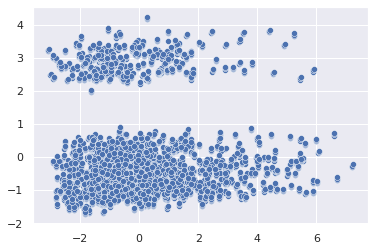

In [44]:
# let's visualize the reduced data
sns.scatterplot(data_reduced_pca[:,0],data_reduced_pca[:,1])

The figure again illustrates that there are two predominant components and that one component is larger in observations than the other.

For the next step, we are bringing some categorical data back for further insides.

In [45]:
vis_data = pd.DataFrame(data_reduced_pca)
vis_data['Attrition'] = data['Attrition']
vis_data['JobRole'] = data['JobRole']
vis_data.columns = ['x', 'y', 'Attrition', 'JobRole']

In [46]:
alt.Chart(vis_data).mark_circle(size=60).encode(
    x='x',
    y='y',
    tooltip=['Attrition', 'JobRole']
).interactive()

alt.Chart(...)

Because of the tooltip, we are able to explore the two components using some categorical data ("Attrition" and "JobRole"). These informationen seem to be somewhat equally distributed, and we can say, that this delivers no information about the essences of the two components. Which gets us to the next step: 

To find out which variables primarily represent the components, we use a heat map:

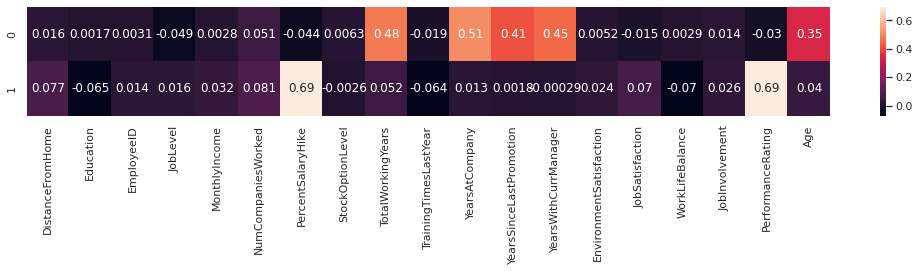

In [47]:
plt.figure(figsize=(18,2))
sns.heatmap(pd.DataFrame(pca.components_, columns=data_to_cluster.columns), annot=True)

From looking at the components, we can say, that the first component (here with the index 0) is grouping the variables that contain the factor "years". So we can observe the correlations between "Total Working Years", "Years at Company", "Years Since Last Promotion","Years With Current Manager" and "Age". We could name this component "Lifetime at/with work", the second component (index 1) have a strong correlation between "Percent Salary Hike" and "Performance Rating", so we could name it "Performance Outcomes". 

Let's have a quick check on the correlations of our original data:

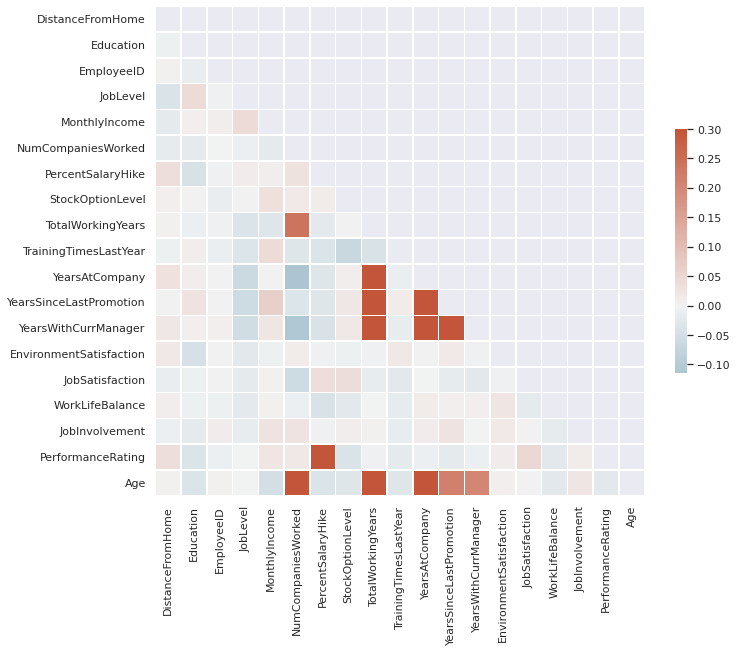

In [48]:
# Compute the correlation matrix
corr = data_to_cluster.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Here we see that the correlations are also present in the unreduced data set. However, through the PCA analysis we gain the aspect of grouping.

##Dimensionality Reduction with Non-Negative Matrix Factorization (NMF)

Since the components of the PCA analysis only explained 15% as the maximum value of variance, it may be useful to test out other grouping methods like the Non-Negative Matrix Factorization (NMF)


In [49]:
# import nmf
from sklearn.decomposition import NMF

With the PCA, we have used 2 components, now we try to find out if the information content changes when we examine 4 components. 

In [50]:
# instantiate with 4 components
nmf = NMF(n_components=4)

In [51]:
# we are using the MinMax Scaler again
data_reduced_nmf = nmf.fit_transform(data_to_cluster_minmax)

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
Maximum number of iterations 200 reached. Increase it to improve convergence.


Let's gain some basic information about the reduced data and the new components.

In [52]:
data_reduced_nmf.shape

(4300, 4)

In [53]:
nmf.components_.shape

(4, 19)

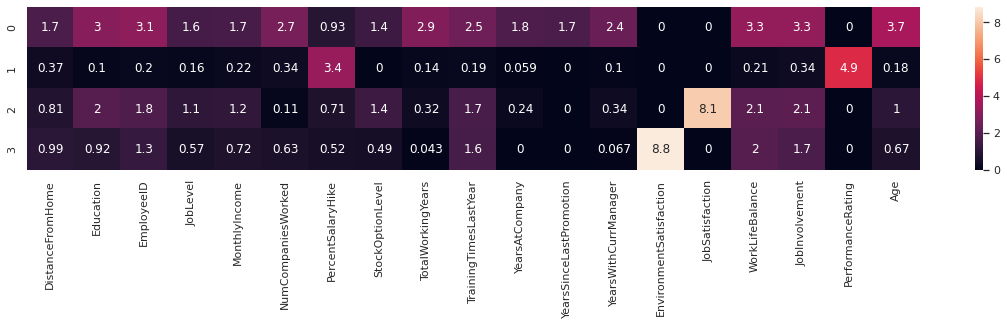

In [54]:
plt.figure(figsize=(20,3))
sns.heatmap(pd.DataFrame(nmf.components_, columns=data_to_cluster.columns), annot=True)

Compared to the PCA, the components have changed. While there is still a component where "Percent Salary Hike" and "Performance Rating" still dominate the component (index 1), the "Years" and "Age"-dominated component have disappeared. In addition, two new components have also been added, where in each case one variable in particular dominates the component. One component is dominated by"Environment Satisfaction" and the other by "Job Satisfaction".

##UMAP

For the next part, we are using UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction). 

In [55]:
#installing the package we need
!pip install umap-learn -q

In [56]:
import umap

In [57]:
# we need the umap scaler for scaling 
umap_scaler = umap.UMAP()

In [58]:
# ...and reducing it to standard-scaled data
embeddings = umap_scaler.fit_transform(data_to_cluster_scaled)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


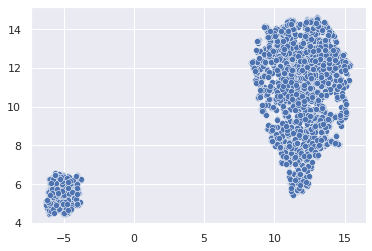

In [59]:
# we plot the umap reduced data
sns.scatterplot(embeddings[:,0],embeddings[:,1])

In [60]:
vis_data = pd.DataFrame(embeddings)
vis_data['Attrition'] = data['Attrition']
vis_data['JobRole'] = data['JobRole']
vis_data.columns = ['x', 'y', 'Attrition', 'JobRole']

In [61]:
alt.Chart(vis_data).mark_circle(size=60).encode(
    x='x',
    y='y',
    tooltip=['Attrition', 'JobRole']
).interactive()

alt.Chart(...)

UMAP also plotted two main components as part of its dimension reduction process. 

##Clustering


The last method we are using to gain a broader picture about our dataset is the clustering method with KMeans.


In [62]:
#Import KMeans
from sklearn.cluster import KMeans




First we have to calculate KMeans to calculate the distances between the data points. Data points that have a small distance between them are grouped in one cluster, while they have the biggest possible distance to the other datapoints grouped in another cluster

In [63]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_to_cluster_scaled)
    Sum_of_squared_distances.append(km.inertia_)

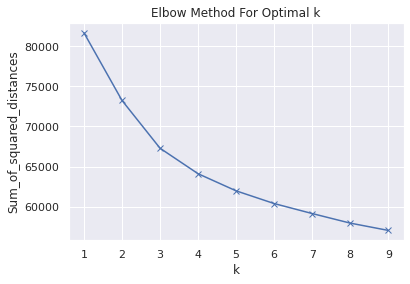

In [64]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

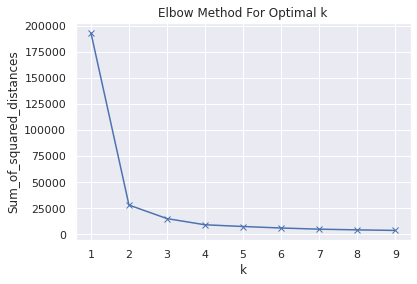

In [65]:
umap_scaler_km = umap.UMAP(n_components=6)
embeddings_km = umap_scaler.fit_transform(data_to_cluster_scaled)


Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(embeddings_km)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


The "Elbow Method" is used to pick the optimal number of clusters. Here the first "bend" ist at 2, so it means, that most of the information is found in two clusters. For further analysis we are going on with two clusters. 

In [66]:
clusterer = KMeans(n_clusters=2) 

In [67]:
clusterer.fit(data_to_cluster_scaled)

KMeans(n_clusters=2)

In [68]:
data['cluster'] = clusterer.labels_

We can now do some exploration with our dataset e.g. which cluster seems most Manager-related. Here we can see, its the cluster with Index 1. 

In [69]:
data.groupby('cluster').YearsWithCurrManager.mean()

cluster
0    2.578145
1    8.074836
Name: YearsWithCurrManager, dtype: float64

For the last examination we are again looking at the mapping of the clusters and try out some of our variables interactively. 

In [70]:
vis_data = pd.DataFrame(embeddings)
vis_data['YearsAtCompany'] = data['YearsAtCompany']
vis_data['cluster'] = data['cluster']
vis_data['PercentSalaryHike'] = data['PercentSalaryHike']
vis_data.columns = ['x', 'y', 'YearsAtCompany', 'cluster','PercentSalaryHike']

In [71]:
alt.Chart(vis_data).mark_circle(size=60).encode(
    x='x',
    y='y',
    tooltip=['YearsAtCompany','PercentSalaryHike'],
    color=alt.Color('cluster:N', scale=alt.Scale(scheme='paired')) 
).interactive()

alt.Chart(...)

## Evaluation

With Unsupervised Machine Learning, an HR team can uncover unknown structures in the dataset and get new impressions about their employees. 
The analysis by the different tools (PCA, NMF, UMAP, Clustering) has shown that a smart dimension reduction is mainly limited to two clusters. Only the method of NMF showed that four clusters are also possible, but in two components (index 2 and 3) only one variable (Job Satisfaction and Environment Satisfaction) is decisive for the component and thus no further connection to other variables is depicted.

For our conclusion we want to focus on the 2-component solutions. 

With Clustering, the HR Team can now see, that there are two ways to group the employees. One group is mostly influenced by Lifetime at/with work. One could say that this group is connected to their work through the years they've spend there. 

The second group is connected to their work mainly through their performance outcomes such as performance rating and salary hike. So taking an active role might be more important for this group than for the first group.

#Supervised Machine Learning (SML)

The HR Team can use Supervised Machine Learning (SML) for predicting the probability of employees leaving the company (Attrition) based of the variables Job Role, Gender, Job Satistisfaction, Years at Company, Number of Companies Worked. 

In [72]:
#This replacement is needed to fit the model later on 
data['Attrition'] = data.Attrition.str.replace('No','0')
data['Attrition'] = data.Attrition.str.replace('Yes','1')

In [73]:
data['Attrition'] = data['Attrition'].astype('float')

## Feature Engineering & Preprocessing SML

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 4408
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Attrition                4300 non-null   float64
 1   BusinessTravel           4300 non-null   object 
 2   Department               4300 non-null   object 
 3   EducationField           4300 non-null   object 
 4   Gender                   4300 non-null   object 
 5   JobRole                  4300 non-null   object 
 6   DistanceFromHome         4300 non-null   int64  
 7   Education                4300 non-null   int64  
 8   EmployeeID               4300 non-null   int64  
 9   JobLevel                 4300 non-null   int64  
 10  MonthlyIncome            4300 non-null   int64  
 11  NumCompaniesWorked       4300 non-null   float64
 12  PercentSalaryHike        4300 non-null   int64  
 13  StockOptionLevel         4300 non-null   int64  
 14  TotalWorkingYears       

In [119]:
#selection of the data for prediction
selected_df = data[['Attrition', 'JobRole','Gender','JobSatisfaction','YearsAtCompany',"NumCompaniesWorked"]]

In [120]:
# we select the X values from selected_df
X = selected_df.iloc[:,1:] 

In [121]:
#we select all rows and the column Attrition(index 0)
Y = selected_df.Attrition 

In [124]:
# transforming categorical values into 0,1
ohe_X = OneHotEncoder(sparse=False)

In [123]:
## the output will be sparse matrix where each column corresponds to one possible value of one feature.
X_ohe = ohe_X.fit_transform(X.iloc[:,0:2]) 


In [126]:
# checking the data
X.iloc[:,0:2]

JobRole  Gender
0     Healthcare Representative  Female
1            Research Scientist  Female
2               Sales Executive    Male
3               Human Resources    Male
4               Sales Executive    Male
...                         ...     ...
4404            Human Resources  Female
4405         Research Scientist  Female
4406      Laboratory Technician    Male
4407            Sales Executive    Male
4408      Laboratory Technician    Male

[4300 rows x 2 columns]

In [82]:
#lets check X_ohe
X_ohe 

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [83]:
#takes a series of iterables and returns one iterable.
columns_X_ohe = list(itertools.chain(*ohe_X.categories_))

In [84]:
ohe_X.categories_

[array(['Healthcare Representative', 'Human Resources',
        'Laboratory Technician', 'Manager', 'Manufacturing Director',
        'Research Director', 'Research Scientist', 'Sales Executive',
        'Sales Representative'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [85]:
#convert it DataFrame
X_cat = pd.DataFrame(X_ohe, columns = columns_X_ohe)

In [86]:
X_cat

Healthcare Representative  Human Resources  Laboratory Technician  \
0                           1.0              0.0                    0.0   
1                           0.0              0.0                    0.0   
2                           0.0              0.0                    0.0   
3                           0.0              1.0                    0.0   
4                           0.0              0.0                    0.0   
...                         ...              ...                    ...   
4295                        0.0              1.0                    0.0   
4296                        0.0              0.0                    0.0   
4297                        0.0              0.0                    1.0   
4298                        0.0              0.0                    0.0   
4299                        0.0              0.0                    1.0   

      Manager  Manufacturing Director  Research Director  Research Scientist  \
0         0.0                     0.0                0.0                 0.0   
1         0.0                     0.0                0.0                 1.0   
2         0.0                     0.0                0.0                 0.0   
3         0.0                     0.0                0.0                 0.0   
4         0.0                     0.0                0.0                 0.0   
...       ...                     ...                ...                 ...   
4295      0.0                     0.0                0.0                 0.0   
4296      0.0                     0.0                0.0                 1.0   
4297      0.0                     0.0                0.0                 0.0   
4298      0.0                     0.0                0.0                 0.0   
4299      0.0                     0.0                0.0                 0.0   

      Sales Executive  Sales Representative  Female  Male  
0                 0.0                   0.0     1.0   0.0  
1                 0.0                   0.0     1.0   0.0  
2                 1.0                   0.0     0.0   1.0  
3                 0.0                   0.0     0.0   1.0  
4                 1.0                   0.0     0.0   1.0  
...               ...                   ...     ...   ...  
4295              0.0                   0.0     1.0   0.0  
4296              0.0                   0.0     1.0   0.0  
4297              0.0                   0.0     0.0   1.0  
4298              1.0                   0.0     0.0   1.0  
4299              0.0                   0.0     0.0   1.0  

[4300 rows x 11 columns]

In [87]:
data['Department'].value_counts()

Research & Development    2807
Sales                     1307
Human Resources            186
Name: Department, dtype: int64

In [88]:
data['EducationField'].value_counts()

Life Sciences       1766
Medical             1364
Marketing            469
Technical Degree     384
Other                237
Human Resources       80
Name: EducationField, dtype: int64

In [89]:
scaler = StandardScaler()

In [90]:
#Scaling all the numerical values to make them comparable

transformed_nummerical = scaler.fit_transform(X.iloc[:,2:])

In [91]:
X.iloc[:,2:] = transformed_nummerical

In [92]:
X.iloc[:,2:]

JobSatisfaction  YearsAtCompany  NumCompaniesWorked
0            1.157359       -0.980272           -0.677226
1           -0.657940       -0.329582           -1.077952
2           -0.657940       -0.329582           -0.677226
3            1.157359        0.158435            0.124225
4           -1.565590       -0.166910            0.524950
...               ...             ...                 ...
4404         1.157359       -0.166910           -0.677226
4405        -1.565590       -0.654927            0.124225
4406         1.157359       -0.654927           -0.276501
4407         0.249709       -0.492255           -1.077952
4408        -1.565590        0.321108           -1.077952

[4300 rows x 3 columns]

In [93]:
#turning the categorical variables into split columns 
X.index = range(len(X))
X_cat.index = range(len(X_cat))

In [94]:
X_enc = X.iloc[:,2:].join(X_cat)

In [95]:
X_enc

JobSatisfaction  YearsAtCompany  NumCompaniesWorked  \
0            1.157359       -0.980272           -0.677226   
1           -0.657940       -0.329582           -1.077952   
2           -0.657940       -0.329582           -0.677226   
3            1.157359        0.158435            0.124225   
4           -1.565590       -0.166910            0.524950   
...               ...             ...                 ...   
4295         1.157359       -0.166910           -0.677226   
4296        -1.565590       -0.654927            0.124225   
4297         1.157359       -0.654927           -0.276501   
4298         0.249709       -0.492255           -1.077952   
4299        -1.565590        0.321108           -1.077952   

      Healthcare Representative  Human Resources  Laboratory Technician  \
0                           1.0              0.0                    0.0   
1                           0.0              0.0                    0.0   
2                           0.0              0.0                    0.0   
3                           0.0              1.0                    0.0   
4                           0.0              0.0                    0.0   
...                         ...              ...                    ...   
4295                        0.0              1.0                    0.0   
4296                        0.0              0.0                    0.0   
4297                        0.0              0.0                    1.0   
4298                        0.0              0.0                    0.0   
4299                        0.0              0.0                    1.0   

      Manager  Manufacturing Director  Research Director  Research Scientist  \
0         0.0                     0.0                0.0                 0.0   
1         0.0                     0.0                0.0                 1.0   
2         0.0                     0.0                0.0                 0.0   
3         0.0                     0.0                0.0                 0.0   
4         0.0                     0.0                0.0                 0.0   
...       ...                     ...                ...                 ...   
4295      0.0                     0.0                0.0                 0.0   
4296      0.0                     0.0                0.0                 1.0   
4297      0.0                     0.0                0.0                 0.0   
4298      0.0                     0.0                0.0                 0.0   
4299      0.0                     0.0                0.0                 0.0   

      Sales Executive  Sales Representative  Female  Male  
0                 0.0                   0.0     1.0   0.0  
1                 0.0                   0.0     1.0   0.0  
2                 1.0                   0.0     0.0   1.0  
3                 0.0                   0.0     0.0   1.0  
4                 1.0                   0.0     0.0   1.0  
...               ...                   ...     ...   ...  
4295              0.0                   0.0     1.0   0.0  
4296              0.0                   0.0     1.0   0.0  
4297              0.0                   0.0     0.0   1.0  
4298              1.0                   0.0     0.0   1.0  
4299              0.0                   0.0     0.0   1.0  

[4300 rows x 14 columns]

## Splitting and training the data 

In [96]:
#splitting the data for testing and training 
X_train, X_test, Y_train, Y_test = train_test_split(X_enc, Y, test_size=0.2, random_state = 42)

In [97]:
#create models to compare their accuracy
model_xgb = XGBRegressor()

In [98]:
model_lg = LogisticRegression()

model_el = ElasticNet()

model_rf = RandomForestRegressor(n_estimators=25)

model=RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=21)

In [99]:
model_xgb.fit(X_train, Y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [100]:
model_lg.fit(X_train, Y_train)

model_el.fit(X_train, Y_train)

model_rf.fit(X_train, Y_train)

model.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=21)

In [101]:
print('Model XGB' + ' ' + str(model_xgb.score(X_train, Y_train)))

Model XGB 0.7853848605042044


In [102]:
#Check the accuracy with dot-score on the training model 
print('Model LG' + ' ' + str(model_lg.score(X_train, Y_train)))

print('Model EL' + ' ' + str(model_el.score(X_train, Y_train)))

print('Model RF' + ' ' + str(model_rf.score(X_train, Y_train)))

print('Model ' + ' ' + str(model.score(X_train, Y_train)))

Model LG 0.8395348837209302
Model EL 0.0
Model RF 0.8336459697417746
Model  0.9659883720930232


##Evaluation

In [103]:
# predict the test data 
Y_pred = model_xgb.predict(X_test)

In [104]:
# calculating the mean squared error to check for fitting
mean_squared_error(Y_test, Y_pred, squared=False)

0.22394067272644927

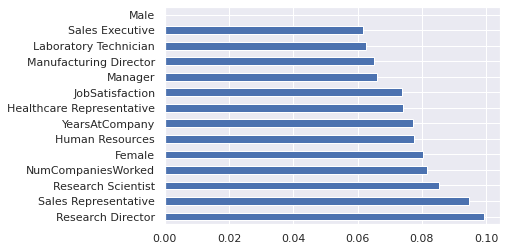

In [105]:
# check which variables influence the model the most 
feat_importances = pd.Series(model_xgb.feature_importances_, index=X_enc.columns)

feat_importances.nlargest(20).plot(kind='barh')

In [107]:
2wexplainer = shap.TreeExplainer(model_xgb)

In [108]:
shap_values = explainer.shap_values(X_enc)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


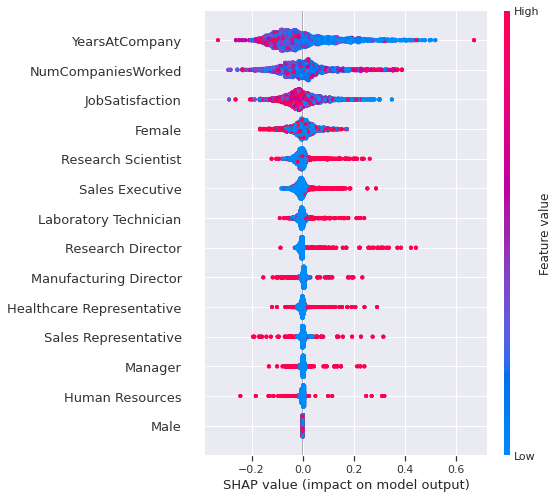

In [109]:

shap.summary_plot(shap_values, X_enc)

The shap values shows the impact of the feature depending on its values. ie. for Years at company the single outlier to the left has been there for a long time, which results in him being less likely to leave/fired.

We are saving our model with pickle:

In [110]:
model_xgb.save_model('model_xgb.json')

In [111]:
pickle.dump(scaler, open('scaler.pkl','wb'))

In [112]:
pickle.dump(ohe_X, open('ohe.pkl','wb'))

In [113]:
X.to_json('X.json')

selected_df.to_json('selected_df.json')

In [114]:
pickle.dump(model_xgb, open('model.pkl','wb'))

In [115]:
pickle.dump(shap_values, open('shap_values.pkl','wb'))

In [116]:
pickle.dump(model_xgb, open('model_xgb.pkl','wb'))

##Summary

With supervised machine learning the HR department gains some insight as to which employees are in danger of leaving. Which can be usefull as a tool for preliminary action to avoid interruption in workflows which occur when an employee leaves. 

After seperating the data into training and test sets we tested 4 models to find out which had the highest precision. Unfortunately we had some issues implementing the the models with the highest precision ability which is why we defaulted to using the xgb model regardless of it having the lowest score.